# Ensemble Analysis

This notebook reads in and formats outputs from ensemble simulations so that you can evaluate and plot

### Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os


#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

# Setup static variables

In [2]:
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers
dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ensembles = [[3, 3, 3, 3, 3, 3, 3],
             [3, 3, 1, 3, 3, 3, 3],
             [3, 3, 3, 1, 3, 3, 3]]
             #[3, 3, 3, 3, 3, 3, 1],
             #[2, 2, 3, 3, 2, 2, 3],
             #[2, 2, 1, 3, 2, 2, 3],
             #[2, 2, 3, 1, 2, 2, 3],
             #[2, 2, 3, 3, 2, 2, 1],
             #[2, 2, 1, 1, 2, 2, 1],
             #[1, 1, 1, 1, 1, 1, 1]]

n_ens = len(ensembles)
print(n_ens, 'Ensembles to evaluate')


3 Ensembles to evaluate


## Read in outputs across all ensemble members and store as arrays 

In [6]:
#setup arrays to store the values
head_array = np.zeros((len(ensembles), nlay, ncol, nrow))
frf_array = np.zeros((len(ensembles),  nlay, ncol, nrow))
fff_array = np.zeros((len(ensembles),  nlay, ncol, nrow))
recharge_array = np.zeros((len(ensembles),  1, ncol, nrow))
et_array = np.zeros((len(ensembles),  1, ncol, nrow))
stor_array = np.zeros((len(ensembles),  1, ncol, nrow))
leakage_array = np.zeros((len(ensembles), 49)) #Note this is the only array that is 2D

# Loop through the ensembles and read the data
root_name = 'static_ensemble_' #root of the run names
for i in range(len(ensembles)):
    print('Assembling outputs for simulation ', i+1, ' of ', len(ensembles))
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc') 
    print('Head and water budget read in for ensemble member ', i+1)  
    
    head_array[i, :, :, :] = headobj.get_data(totim=1.0)
        
    tempfrf = np.squeeze(budgobj.get_data(text='flow right face', totim=1.0))
    frf_array[i, :, :, :] = tempfrf
        
    tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE', totim=1.0))
    fff_array[i, :, :, :] = tempfff

    temprch = np.squeeze(budgobj.get_data(text='RECHARGE', totim=1.0))
    recharge_array[i,  :, :, :] = temprch[1]

    tempet = np.squeeze(budgobj.get_data(text='ET', totim=1.0))
    et_array[i, :, :, :] = tempet[1]

    templeak = budgobj.get_data(text='RIVER LEAKAGE', totim=1.0)
    leakage_array[i, :] = templeak[0].q




Assembling outputs for simulation  1  of  3
Head and water budget read in for ensemble member  1
Assembling outputs for simulation  2  of  3
Head and water budget read in for ensemble member  2
Assembling outputs for simulation  3  of  3
Head and water budget read in for ensemble member  3


## Examples grabbing out values of interest from arrays
See below for some examples grabbing out values of interest. I'm not plotting them here you can either plot them in python or just copy values into excel for your plotting. 

### Notes: 
1. Remeber for all arrays except for river leakage the structure is: array_name[ensemble_number, vertical_layer, row, column]
2. River Leakage only has values for the river cells so its structure is: leakage_array[ensemble_number, column]
3. I have provided ET as an example here. There are arrays for fluxes recharge, head and storage that all have the same structure so you can just swap out the et_array name for one of the other names (e.g. 'head_array') to get values for that out. 

In [4]:
#print out the values for any of the stored arrays for all ensemble members. Every example below will print out one number for each ensemble member. 

#  ET at a single location in this case row 22, column 15
et_sigle_loc = et_array[:, 0, 22, 15]
print("ET at one location:")
print(et_sigle_loc) 

# ET summed across the domain
# Note here I am summing for all rows and all columns but you could change sum across any area by changing the row and column ranges provided
et_sum=np.zeros(len(ensembles))
for i in range(len(ensembles)):
    et_sum[i]= np.sum(et_array[i, 0, :,:])
print("Total ET:")
print(et_sum)

#  River leakage a single location, column 25
leak_sigle_loc = leakage_array[:, 25]
print("Leakage at one location:")
print(leak_sigle_loc) 

#  River leakage a single location, column 25
leak_total = np.sum(leakage_array, axis=1)
print("Total Leakage:")
print(leak_total) 

ET at one location:
[-245.87313843 -245.87313843 -243.22807312]
Total ET:
[-102193.29556926 -102193.29556926 -101519.52342525]
Leakage at one location:
[-5458.31835938 -5458.31835938 -5178.50976562]
Total Leakage:
[334338.70860291 334338.70860291 357758.31034851]


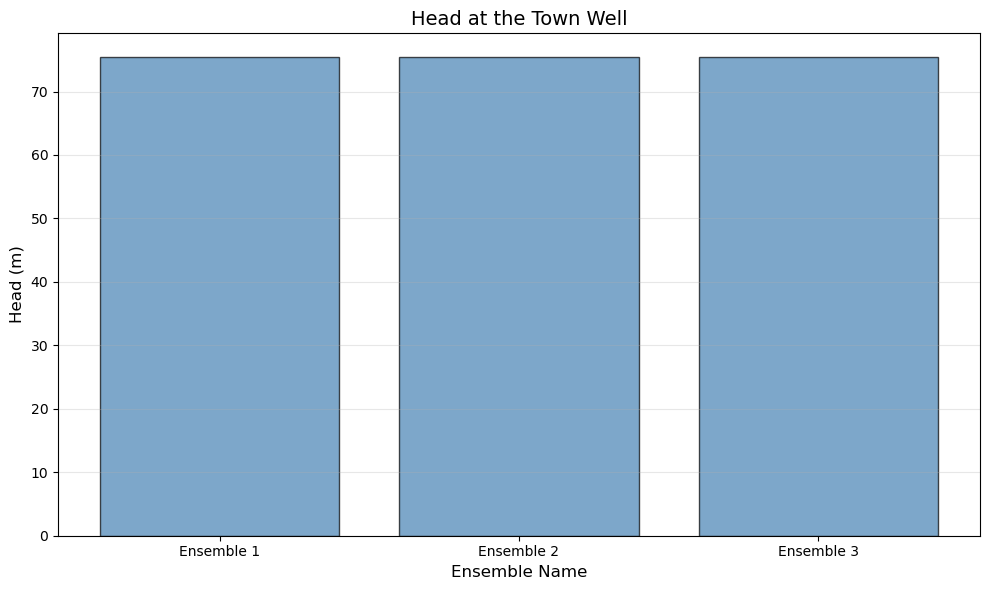

Head values at location (0, 21, 38):
Ensemble 1: 75.40 m
Ensemble 2: 75.40 m
Ensemble 3: 75.38 m


In [8]:
# Extract head at the specified well location for each ensemble member
well_loc = (0, 21, 38)  # (layer, row, column)
head_at_well = head_array[:, well_loc[0], well_loc[1], well_loc[2]]

# Create ensemble names
ensemble_names = [f'Ensemble {i+1}' for i in range(len(ensembles))]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(ensemble_names, head_at_well, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Ensemble Name', fontsize=12)
plt.ylabel('Head (m)', fontsize=12)
plt.title(f'Head at the Town Well', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Head values at location {well_loc}:")
for i, (name, head) in enumerate(zip(ensemble_names, head_at_well)):
    print(f"{name}: {head:.2f} m")
